# Dry Conditions
 


```{glue:figure} number_dry_days
:scale: 60%
:align: center
```

```{glue:figure} maximum_cons_dry_days
:scale: 60%
:align: center
```

**Figure. Annual dry days (top) and maximum number of consecutive days (bottom) over the period 1951–2024 at Koror.**  Dry days are defined as days below 1mm (0.04 inches) threshold.  Consecutive dry days is a measure of the longest sequence of days in a year where rainfall is less than 1 mm (0.04 inches). The dashed black line represents a trend that is not statistically significant.  

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path as op
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize


sys.path.append("../../../functions")
from data_downloaders import GHCN, filter_by_time_completeness
from rain_func import consecutive_dry_days, count_consecutive_days

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

### Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

### Observations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

In [7]:
df_filt, removed_months, removed_years = filter_by_time_completeness(
    data,
    month_threshold=0.75,
    year_threshold=0.75
)
print(f"Removed {removed_months.shape[0]} months due to insufficient data: {removed_months.index.tolist()}")
print(f"Removed {removed_years.shape[0]} years due to insufficient data: {removed_years.index.tolist()}")

data = df_filt #replace data with filtered data
data_daily = data.copy()

Removed 9 months due to insufficient data: [(2018, 8), (2019, 1), (2022, 7), (2022, 11), (2022, 12), (2023, 1), (2023, 8), (2024, 2), (2025, 10)]
Removed 1 years due to insufficient data: [2019]


In [8]:
data['wet_day'] = np.where(data['PRCP'] > 1, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Text(0, 0.5, 'Number of Days')

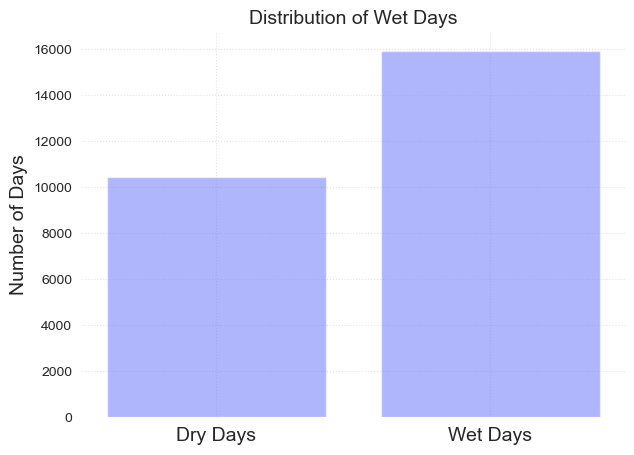

In [9]:
fig, ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)
ax.set_ylabel('Number of Days', fontsize = fontsize)    

## Analysis

#### Number of days over and above 1mm threshold

The following plot analyzes the number of wet (over 1mm) and dry days over time <br>
Dry days are considered those in which precipitation is lower than 1mm. <br>

In [10]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [11]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

### Plotting

Text(0, 0.5, 'Number of days')

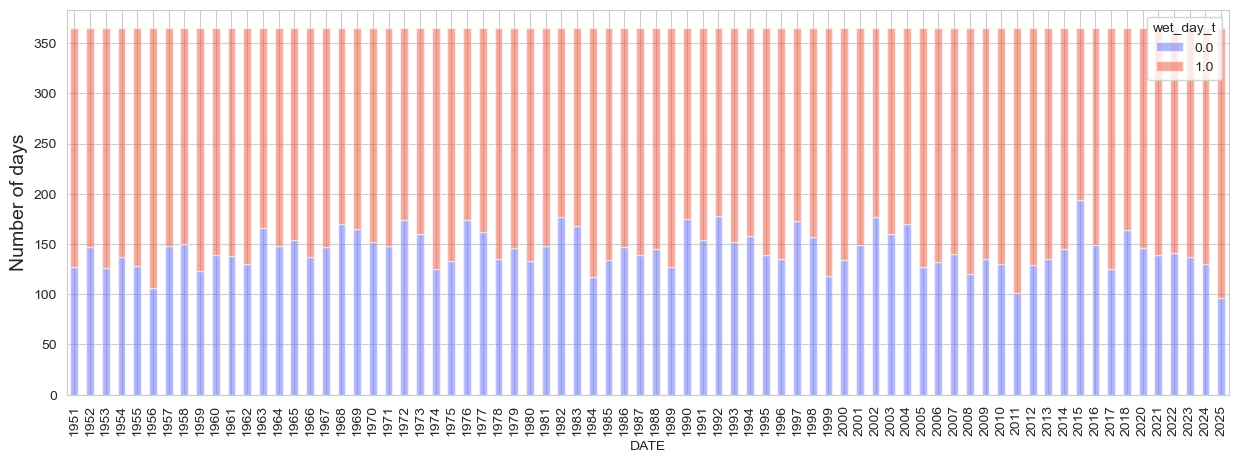

In [12]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

The following plot analyzes  the number of dry days over time as well the trend over time

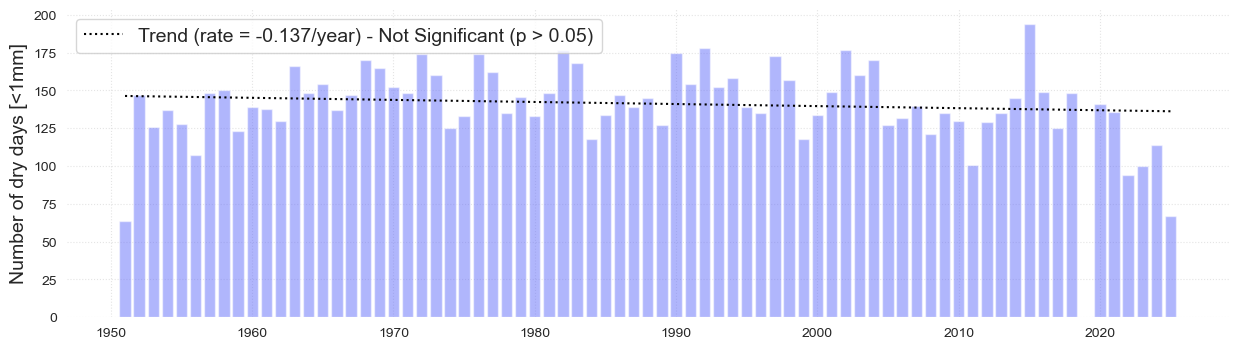

In [13]:
#Dry days
data2 = data.loc[data['wet_day_t'] == 0]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend_dry_days = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of dry days [<1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F6a_Number_dry.png'), dpi=300, bbox_inches='tight')
glue("number_dry_days", fig, display=False)
glue('trend_dry', float(trend_dry_days), display=False)


In [14]:
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()
data['dry_day'] = np.where(data['PRCP'] < threshold, 1, 0)

In [15]:
consecutive_dry_year = data.groupby(data.index.year)['dry_day'].apply(consecutive_dry_days)
data['below_threshold'] = data['PRCP'] < threshold
data['consecutive_days'] = count_consecutive_days(data['below_threshold'])

#### Number of consecutive dry days

The following plot represents the average number of consecutive dry days which are considered those in which precipitation is lower than 1mm. <br>

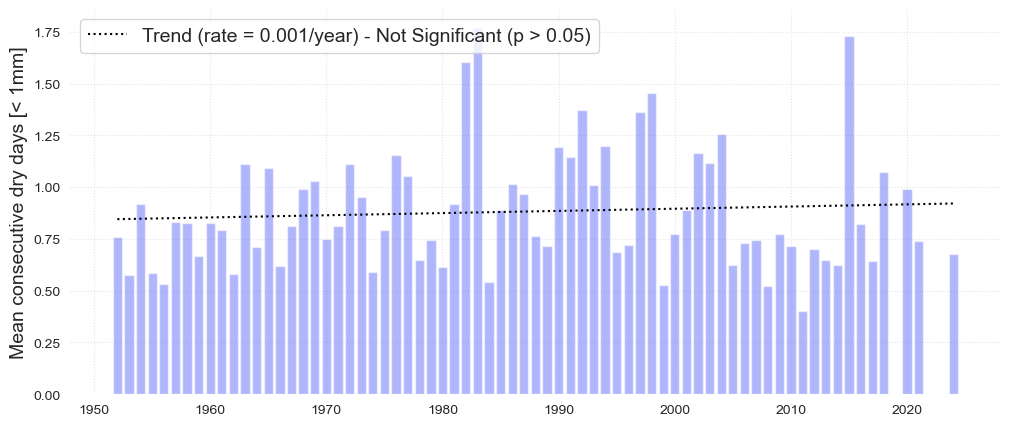

In [16]:
fig, ax = plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].mean(), 
               trendline =True, y_label = 'Mean consecutive dry days [< 1mm]',
               figsize = [12, 5])
glue("mean_dry_days_fig", fig, display=False)



The following plot represents the maximum number of dry days which are considered those in which precipitation is lower than 1mm. <br>

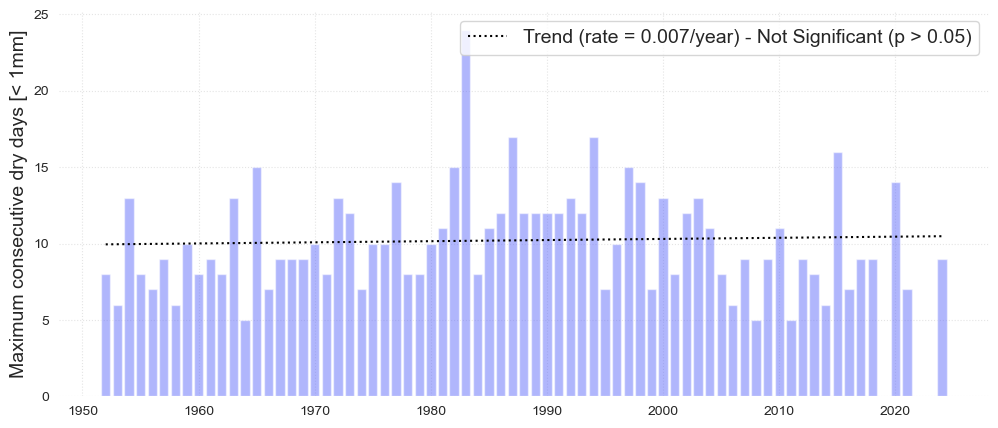

In [17]:
fig, ax, trend_max_ndays = plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].max(), 
               trendline =True, y_label = 'Maximum consecutive dry days [< 1mm]', return_trend = True,
               figsize = [12, 5])

glue("maximum_cons_dry_days", fig, display=False)

plt.savefig(op.join(path_figs, 'F6b_Consecutive_dry.png'), dpi=300, bbox_inches='tight')


### Table
Table sumarizing different metrics of the data analyzed in the plots above

In [18]:
from ind_setup.tables import style_matrix, table_rain_22

In [19]:
style_matrix(table_rain_22(data, trend_dry_days, trend_max_ndays), title = 'Dry Conditions')

Metric,Value
Annual Average Number of Dry Days [<1mm],144.800
Change in Number of Dry Days since 1951,-10.001
Rate of Change in Number of Dry Days (days/year),-0.137
Average Number of Dry Days: 1951 - 1962,125.182
Average Number of Dry Days: 2012 - 2021,136.667
Number of dry days in the driest year on record (2015),181.000
,
Maximum number of consecutive dry days on record,24.000
Change in Maximum Consecutive Dry Days since 1951,0.511
Rate of Change in Maximum Consecutive Dry Days (days/year),0.007
